In [1]:
import numpy as np
import torch

In [2]:
K = 7; N = 64; d = 128

In [6]:
z = np.random.randn(N, d)
s = np.random.randn(K, d)
Sigma = np.random.randn(K, d)

In [4]:
(z[None, ...] - s[:, None, :]).shape

(7, 64, 128)

In [7]:
(z[None, ...]/Sigma[:, None, :]).shape

(7, 64, 128)

In [11]:
((z[None, ...] - s[:, None, :]).dot((z[None, ...] - s[:, None, :]).T)).shape

ValueError: shapes (7,64,128) and (128,64,7) not aligned: 128 (dim 2) != 64 (dim 1)

In [2]:
from sklearn import cluster, datasets
import matplotlib.pyplot as plt

n_samples = 1500
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170
)

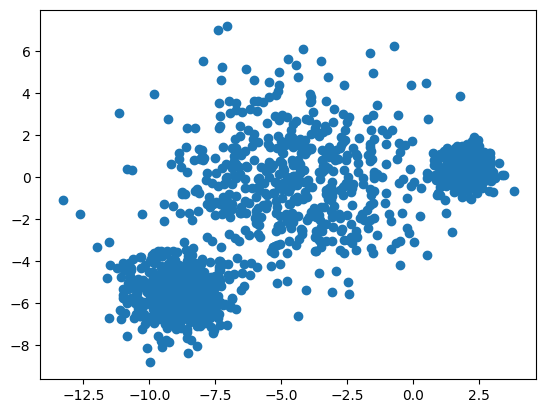

In [3]:
plt.scatter(varied[0][:,0], varied[0][:, 1])
plt.show()

In [135]:
from sklearn.mixture import GaussianMixture

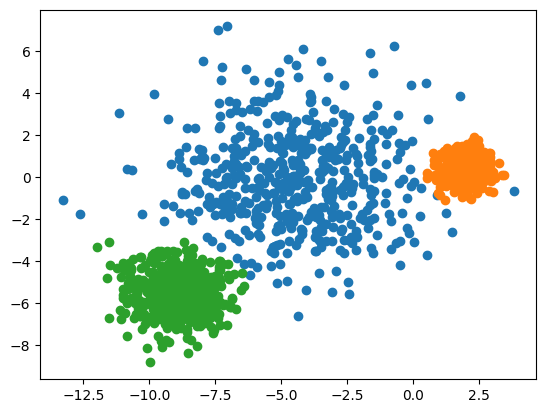

In [382]:
bgm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42).fit(varied[0])
responsibilities = bgm.predict(varied[0])

nc=3
for c in range(nc):
    plt.scatter(varied[0][responsibilities == c ][:,0], 
                    varied[0][responsibilities == c ][:, 1])

plt.show()

In [208]:
A = np.random.randn(8, 6, 32)
B = np.random.randn(8, 6, 32)
np.tensordot(A, B, axes=([0, 2],[0, 2])).shape

(6, 6)

# Different K, V functions

In [58]:
import torch

def seed_all(seed = 2023, deterministic=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_all()

In [419]:
import torch
from torch import Tensor, nn
from typing import Dict, List, Optional, Tuple
from torch.distributions import Normal
 
class GMM:
    """
    Class to implement the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models (GMM) using PyTorch.
 
    Attributes:
    - num_components: int
        Number of components in the GMM.
    - num_features: int
        Number of features in the data.
    - means: torch.Tensor
        Tensor to store the means of the Gaussian components.
    - covariances: torch.Tensor
        Tensor to store the covariance matrices of the Gaussian components.
    - weights: torch.Tensor
        Tensor to store the weights of the Gaussian components.
    """
 
    def __init__(self, num_components: int, num_features: int):
        """
        Constructor to instantiate the GMM class.
 
        Parameters:
        - num_components: int
            Number of components in the GMM.
        - num_features: int
            Number of features in the data.
        """
 
        self.num_components = num_components
        self.num_features = num_features
        self.eps = 1e-8

        self.to_q = nn.Identity() # Linear(self.num_features, self.num_features).eval()
        self.to_k = nn.Identity() # Linear(self.num_features, self.num_features).eval()
        self.to_v = nn.Identity() # Linear(self.num_features, self.num_features).eval()

    
    
    def EM_step(self, slots_prev: Tensor, sigma_prev: Tensor, pi_prev: Tensor, k: Tensor, v: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        # Sigma: K x d
        # K: N x d
        # pi_prev: K x 1

        b, N, d = k.shape
        _, K, _ = slots_prev.shape

        q = self.to_q(slots_prev)

        # E-step
        diff = k.unsqueeze(1) - q.unsqueeze(2)  # K x N x d
        inv_sigma = 1.0 / sigma_prev.unsqueeze(2)  # K x 1 x d
        exponent = -0.5 * torch.sum((diff * inv_sigma)**2, dim=3)

        log_pi = torch.log(torch.clamp(pi_prev, min=1e-6))
        log_normalization = torch.log(torch.clamp(np.sqrt(2*np.pi) * torch.sum(sigma_prev, dim=2, keepdim=True), min=1e-6))

        dots = exponent + log_pi - log_normalization
        attn = dots.softmax(dim=1)

        # M-step
        Nk = attn.sum(dim=-1, keepdim=True) + self.eps
        pi = Nk / N
        slots = (1 / Nk) * torch.einsum('bnd,bkn->bkd', v, attn)
        # slots = (1 / Nk) * torch.sum(v.unsqueeze(1)*attn.unsqueeze(-1), dim = 2)


        # diff = torch.sum(v.unsqueeze(1) - slots.unsqueeze(2), dim = 1)  # K x N x d
        # sigma = (1 / Nk) * torch.einsum('bjd,bij->bid', diff**2, attn) + self.eps

        diff = v.unsqueeze(1) - slots.unsqueeze(2) # K x N x d
        sigma = (1 / Nk) * torch.sum((diff**2)*attn.unsqueeze(-1), dim=2) + self.eps

        print (sigma.min(), sigma.max())
        # sigma_norm = torch.norm(sigma, 2, keepdim=True)
        # sigma = sigma / (sigma_norm + 1e-6)

        return slots, pi, sigma, attn

        
    
    def fit(self, data: torch.Tensor, num_iterations: int):
        """
        Fits the GMM to the given data using the EM algorithm.
 
        Parameters:
        - data: torch.Tensor
            Tensor containing the data points.
        - num_iterations: int
            Number of iterations to run the EM algorithm.
 
        Returns:
        - torch.Tensor:
            Tensor containing the responsibilities for each data point and component after the final iteration.
        """
        data = (data - data.min(0, keepdim=True)[0])/(data.max(0, keepdim=True)[0] - data.min(0, keepdim=True)[0] + self.eps)
        # data = data/data.max(0, keepdim=True)[0]

        data = data.unsqueeze(0).type(torch.float32) # B x 1 x d
        
        k = self.to_k(data)
        v = self.to_v(data)

        # Initialize the means, covariances, and weights randomly
        # mean = np.array([[-9.5, -6.0], [-3.5, 0], [2.5, 0]])
        # slots = torch.from_numpy(mean).type(torch.float32).unsqueeze(0)
        slots = torch.randn(data.shape[0],self.num_components, self.num_features)
        sigma = torch.ones(data.shape[0],self.num_components, self.num_features)
        pi = torch.ones(data.shape[0], self.num_components, 1)/self.num_components

        print (slots, sigma)
        for _ in range(num_iterations):
           slots, pi, sigma, attn = self.EM_step(slots, sigma, pi, k, v)
 
        return data[0].numpy(), attn.squeeze().t(), slots, sigma
 
# Example usage of the GMM class:
 
# Initialize the GMM with 2 components and 2 features
gmm = GMM(num_components=3, num_features=2)
 
# Fit the GMM to the data using the EM algorithm for 10 iterations
data, responsibilities, slots, sigma = gmm.fit(torch.from_numpy(varied[0]), num_iterations=10000)
 
# Print the responsibilities for the data points after the final iteration
print(responsibilities.shape)
print(responsibilities)

tensor([[[ 0.2120, -0.8634],
         [-0.9012,  1.6933],
         [-0.3122, -1.8428]]]) tensor([[[1., 1.],
         [1., 1.],
         [1., 1.]]])
tensor(0.0356) tensor(0.0782)
tensor(0.0051) tensor(0.0460)
tensor(0.0036) tensor(0.0395)
tensor(0.0034) tensor(0.0397)
tensor(0.0029) tensor(0.0399)
tensor(0.0023) tensor(0.0398)
tensor(0.0008) tensor(0.0398)
tensor(1.1370e-05) tensor(0.0379)
tensor(1.0000e-08) tensor(0.0385)
tensor(1.0000e-08) tensor(0.0649)
tensor(1.0000e-08) tensor(0.0764)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.0765)
tensor(1.0000e-08) tensor(0.07

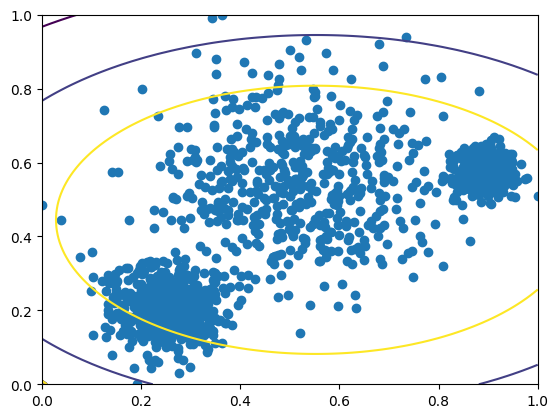

In [420]:
nc = responsibilities.shape[-1]
responsibilities = responsibilities.argmax(1).numpy()

from scipy.stats import multivariate_normal

for c in range(gmm.num_components):
    mean = slots[0, c].detach().numpy()
    cov = np.diag(sigma[0, c].detach().numpy())
    rv = multivariate_normal(mean, cov)
    plt.scatter(data[responsibilities == c ][:,0], 
                    data[responsibilities == c ][:, 1])

    x, y = np.meshgrid(np.linspace(data[:, 0].min(), data[:, 0].max(), 100),
                       np.linspace(data[:, 1].min(), data[:, 1].max(), 100))
    xy = np.column_stack((x.ravel(), y.ravel()))
    z = rv.pdf(xy).reshape(x.shape)
    plt.contour(x, y, z, levels=[0.01, 0.1, 0.5])


plt.show()




# same K, V functions

In [111]:
import torch
from torch import Tensor, nn
from typing import Dict, List, Optional, Tuple
from torch.distributions import Normal
 
class GMM:
    """
    Class to implement the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models (GMM) using PyTorch.
 
    Attributes:
    - num_components: int
        Number of components in the GMM.
    - num_features: int
        Number of features in the data.
    - means: torch.Tensor
        Tensor to store the means of the Gaussian components.
    - covariances: torch.Tensor
        Tensor to store the covariance matrices of the Gaussian components.
    - weights: torch.Tensor
        Tensor to store the weights of the Gaussian components.
    """
 
    def __init__(self, num_components: int, num_features: int):
        """
        Constructor to instantiate the GMM class.
 
        Parameters:
        - num_components: int
            Number of components in the GMM.
        - num_features: int
            Number of features in the data.
        """
 
        self.num_components = num_components
        self.num_features = num_features
        self.eps = 1e-8

        self.to_q = nn.Linear(self.num_features, self.num_features).eval()
        self.to_v = self.to_k = nn.Linear(self.num_features, self.num_features).eval()

    
    
    def EM_step(self, slots_prev: Tensor,
                    sigma_prev :Tensor, 
                    pi_prev: Tensor,
                    k: Tensor, 
                    v: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:

        # Sigma: K x d
        # K: N x d
        # pi_prev: K x 1

        b , N, d = k.shape
        _, K, _ = slots_prev.shape

        sigma_prev = sigma_prev**2
        q = self.to_q(slots_prev)

                        
        # E-step
        KSigmaKT = torch.einsum('bkjd, bjd -> bkj', k.unsqueeze(1)/sigma_prev.unsqueeze(2), k)/(N*K) # B x K x N
        QSigmaQT = torch.einsum('bjnd, bjd -> bjn', q.unsqueeze(2)/sigma_prev.unsqueeze(2), q)/K # B x K x 1 
        QSigmaKT = torch.einsum('bid, bjd -> bij', q/sigma_prev, k) # B x K x N 

        dots = -(KSigmaKT + QSigmaQT - 2*QSigmaKT) +\
                torch.log(torch.clamp(pi_prev, min=1e-6)) -\
                torch.log(torch.clamp(np.sqrt(2*np.pi)* torch.norm(sigma_prev, 2, keepdim=True), min=1e-6))
        
        attn = dots.softmax(dim=1) + self.eps
        


        # M-step
        Nk = attn.sum(dim=-1, keepdim=True)
        pi = Nk/N
        slots = torch.einsum('bjd,bij->bid', v, attn)/Nk

        sigma = torch.einsum('bkjd,bkj->bkd', \
                    (v.unsqueeze(1) - slots.unsqueeze(2))**2, attn)/Nk/(N*K) 
        norm = torch.norm(sigma, 2, keepdim=True)
        sigma = sigma/(norm + 1e-3)

        return slots, pi, sigma, attn

    
    def fit(self, data: torch.Tensor, num_iterations: int):
        """
        Fits the GMM to the given data using the EM algorithm.
 
        Parameters:
        - data: torch.Tensor
            Tensor containing the data points.
        - num_iterations: int
            Number of iterations to run the EM algorithm.
 
        Returns:
        - torch.Tensor:
            Tensor containing the responsibilities for each data point and component after the final iteration.
        """
        data = data.unsqueeze(0).type(torch.float32) # B x 1 x d
        
        k = self.to_k(data)
        v = self.to_v(data)

        # Initialize the means, covariances, and weights randomly
        mean = np.array([[-9.5, -6.0], [-3.5, 0], [2.5, 0]])
        slots = torch.from_numpy(mean).type(torch.float32).unsqueeze(0)
        sigma = 0.5*torch.ones(data.shape[0],self.num_components, self.num_features)
        pi = torch.ones(data.shape[0], self.num_components, 1)/self.num_components

 
        for _ in range(num_iterations):
           slots, pi, sigma, attn = self.EM_step(slots, sigma, pi, k, v)
 
        return attn.squeeze().t()
 
# Example usage of the GMM class:
 
# Initialize the GMM with 2 components and 2 features
gmm = GMM(num_components=3, num_features=2)
 
# Fit the GMM to the data using the EM algorithm for 10 iterations
responsibilities = gmm.fit(torch.from_numpy(varied[0]), num_iterations=10000)
 
# Print the responsibilities for the data points after the final iteration
print(responsibilities.shape)
print(responsibilities)

torch.Size([1500, 3])
tensor([[1.0000e-08, 1.0000e+00, 1.0000e-08],
        [1.0000e-08, 1.0000e+00, 1.0000e-08],
        [1.0000e-08, 1.0000e+00, 1.0000e-08],
        ...,
        [1.0000e-08, 1.0000e+00, 1.0000e-08],
        [1.0000e-08, 1.0000e+00, 1.0000e-08],
        [1.0000e-08, 1.0000e+00, 1.0000e-08]], grad_fn=<TBackward0>)


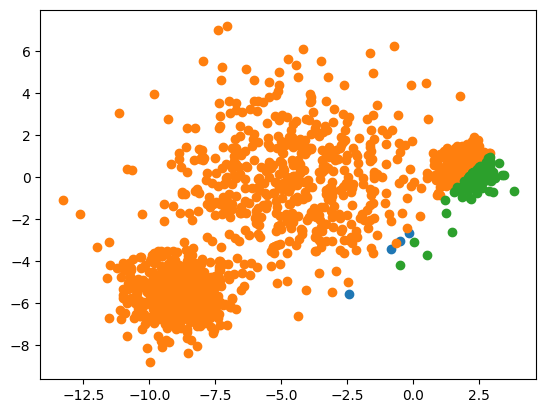

In [112]:
nc = responsibilities.shape[-1]
responsibilities = responsibilities.argmax(1).numpy()
for c in range(nc):
    plt.scatter(varied[0][responsibilities == c ][:,0], 
                    varied[0][responsibilities == c ][:, 1])

plt.show()